# Vehicle value prediction model

This notebook includes a basic linear regression model for estimating the value of a vehicle based on its make, mileage, and age.

## Import and clean the dataset

In [391]:
import pandas as pd
import numpy as np

# Update to include make and model
cols = ["year", "make", "odometer", "sellingprice"]
df = pd.read_csv('data/car_prices.csv', usecols=cols).replace({'-': np.nan, '': np.nan}).dropna()
df['make'] = df['make'].str.lower()

# Filter to only desired makes and models
makes = sorted(['chevrolet', 'ford', 'honda', 'hyundai', 'toyota', 'volkswagen', 'porsche', 'bmw', 'audi', 'mazda'])
df = df[df['make'].isin(makes)]

## Analyze how the age of the vehicle impacts the selling price

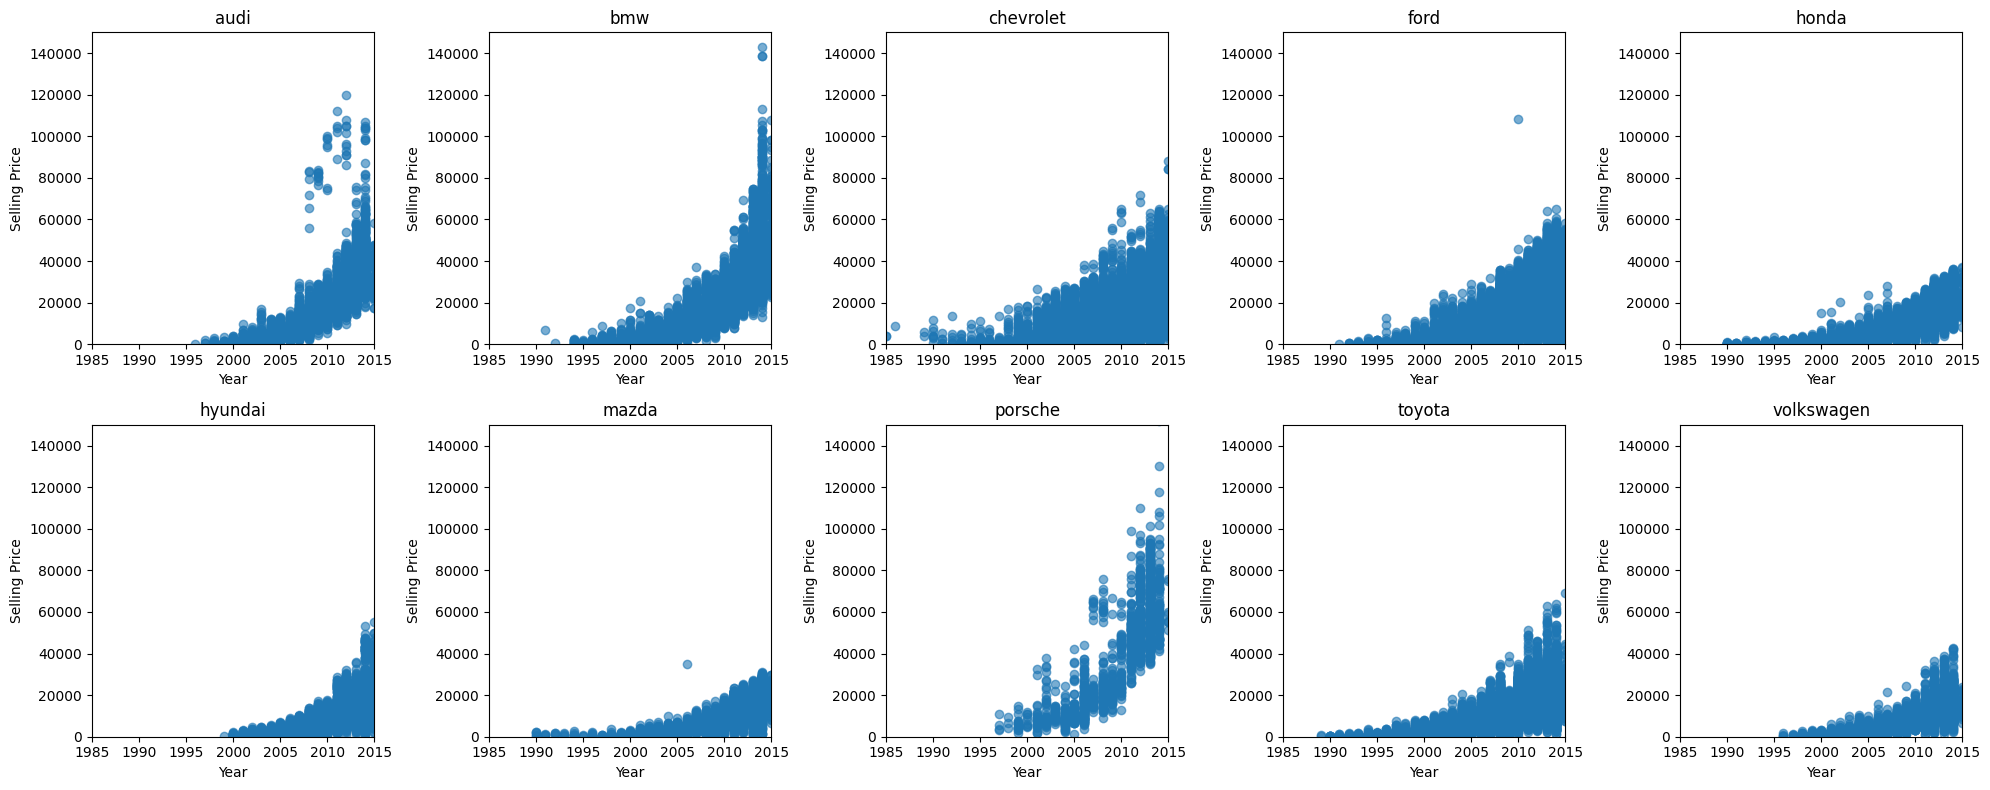

In [392]:
import matplotlib.pyplot as plt

def plot_price_to_year():
    # Find global ranges
    year_min = 1985
    year_max = df['year'].max()
    price_min = 0
    price_max = 150000
    
    # Create a separate plot for each make
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx, make in enumerate(makes):
        mask = df['make'] == make
        axes[idx].scatter(df[mask]['year'], df[mask]['sellingprice'], alpha=0.6)
        axes[idx].set_title(make)
        axes[idx].set_xlabel('Year')
        axes[idx].set_ylabel('Selling Price')
        axes[idx].set_xlim(year_min, year_max)
        axes[idx].set_ylim(price_min, price_max)

    plt.tight_layout()
    plt.show()

plot_price_to_year()

## Analyze how the mileage of the vehicle impacts the selling price

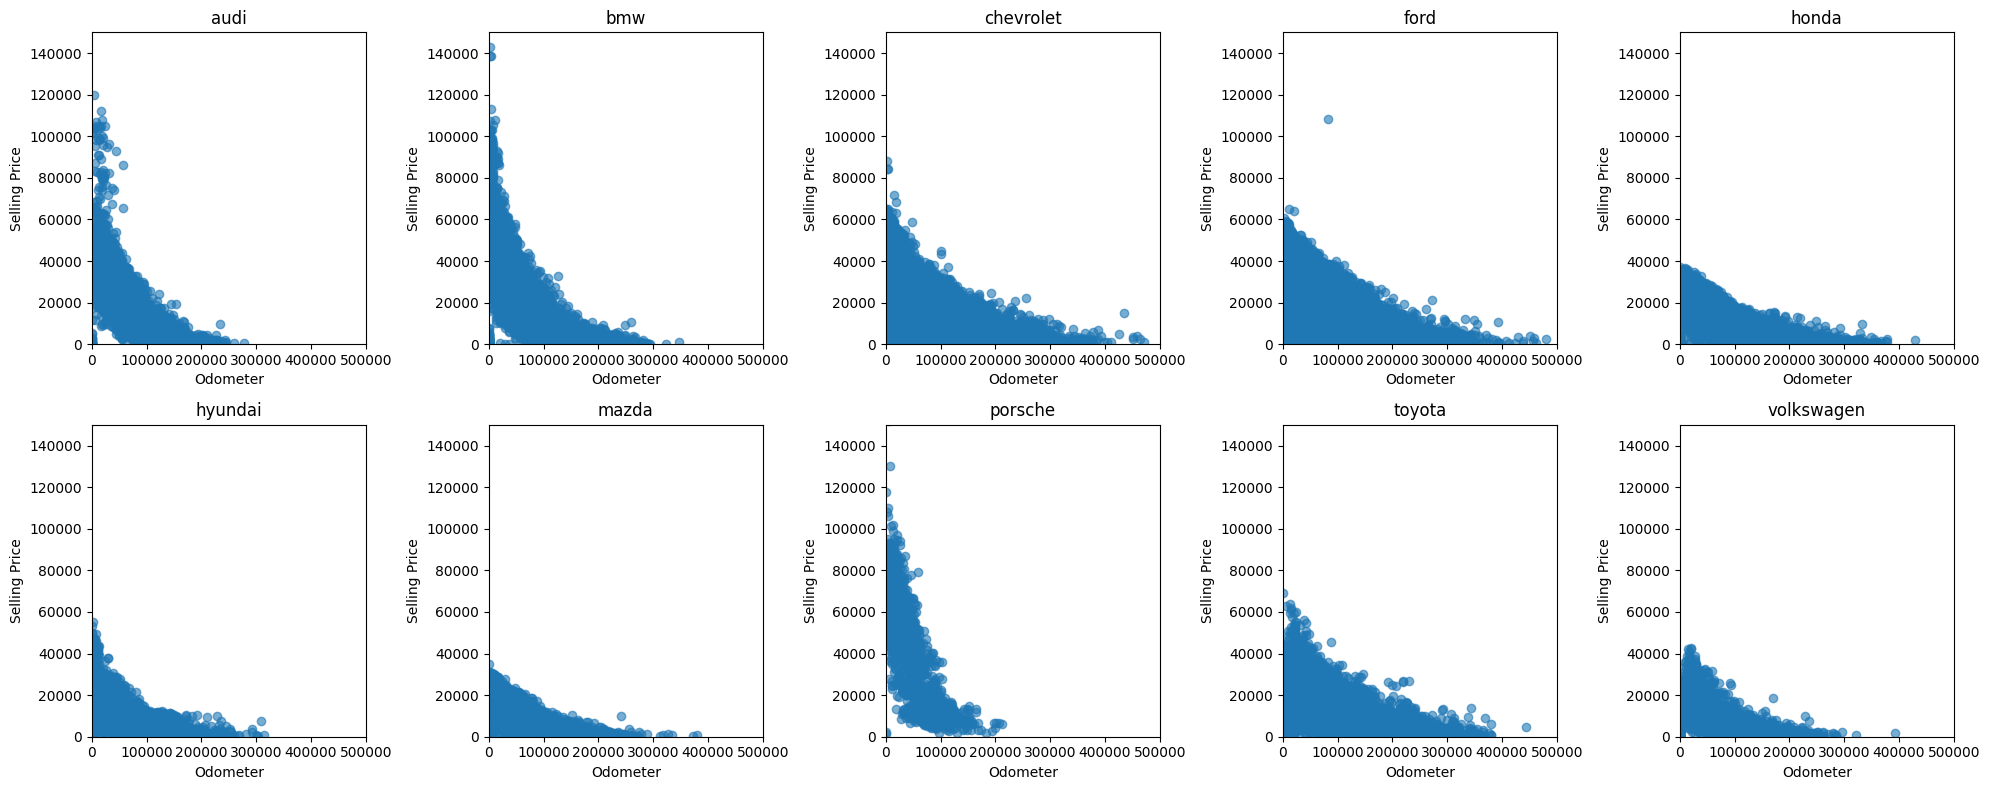

In [393]:
import matplotlib.pyplot as plt

def plot_price_to_mileage():
    # Find global ranges
    mileage_min = 0
    mileage_max = 500000
    price_min = 0
    price_max = 150000
    
    # Create a separate plot for each make
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for idx, make in enumerate(makes):
        mask = df['make'] == make
        axes[idx].scatter(df[mask]['odometer'], df[mask]['sellingprice'], alpha=0.6)
        axes[idx].set_title(make)
        axes[idx].set_xlabel('Odometer')
        axes[idx].set_ylabel('Selling Price')
        axes[idx].set_xlim(mileage_min, mileage_max)
        axes[idx].set_ylim(price_min, price_max)

    plt.tight_layout()
    plt.show()

plot_price_to_mileage()

## Analyze the general distribution of the data

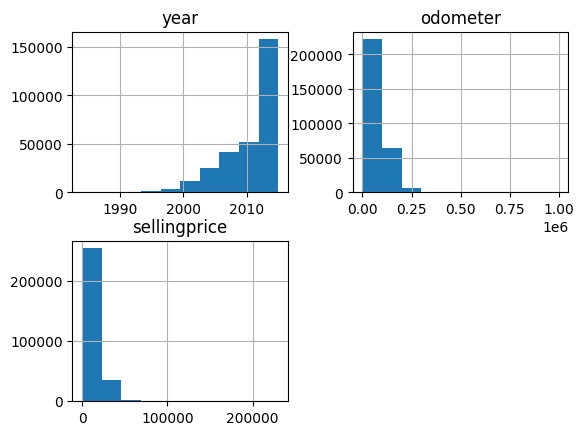

In [394]:
from matplotlib import pyplot

# Generate data distribution histograms
df.hist()
pyplot.show()

## Train the model
- Separate the make column into individual fields for each manufacturer
- Split up our data into training and testing sets
- Train the model using a linear regression approach

In [395]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Choose variables
# Independent variables:
x = pd.get_dummies(df.drop(columns=['sellingprice']), columns=['make'], prefix=['make'])

# Dependent variables
y = df[['sellingprice']].copy()

# Split the model into training and testing sets
# Vectorize makes and models
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=100)

# Train a model on the split dataset
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

## Analyze the general distribution of the data

In [396]:
# Now that we have a working model, we can analyze its accuracy using the testing set
from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = model.predict(x_test.head(10))
y_test_head = y_test.head(10).values
mse = mean_squared_error(y_test_head, y_pred)
rmse = sqrt(mse)
print(f"The average prediction was off by +/- ${rmse:,.2f}")

The average prediction was off by +/- $4,731.52


## User-facing estimator interface
The following interface can be used to estimate the value of a vehicle.

To estimate the value of a vehicle, modify the interface inputs following these guidelines:
| Input | Valid values |
| -------- | ------- |
| make  | One of the following strings: `'chevrolet', 'ford', 'honda', 'hyundai', 'toyota', 'volkswagen', 'porsche', 'bmw', 'audi', 'mazda'`    |
| year | Any integer between `1985` and `2024` |
| mileage_input    | Any integer between `0` and `500000`  |

After inputting the information, an estimate will be presented: e.g. "Estimated value for a 2015 Chevrolet with 50000 miles: $18010.83"

In [397]:
import ipywidgets as widgets
from IPython.display import display

def estimate(vehicle_make: str, year: int, odometer: int):
    input_df = pd.DataFrame([[year, odometer]], columns=['year', 'odometer'])

    # Generate dummies with all categories
    for make in makes:
        col = f'make_{make}'
        if col not in input_df.columns:
            input_df[col] = False

    # Set the individual make value to true
    input_df[f'make_{vehicle_make}'] = True

    return model.predict(input_df)

def create_prediction_widget(model, makes):
    # Create widgets
    make_dropdown = widgets.Dropdown(
        options=makes,
        description='Make:',
        style={'description_width': 'initial'}
    )
    
    year_input = widgets.IntText(
        value=2020,
        description='Year:',
        style={'description_width': 'initial'}
    )

    mileage_input = widgets.IntText(
        value=50000,
        description='Mileage:',
        style={'description_width': 'initial'}
    )
    
    output = widgets.Output()
    
    def on_value_change(change):
        with output:
            output.clear_output()
            estimated_value = estimate(
                make_dropdown.value,
                year_input.value,
                mileage_input.value
            )[0][0].round(2)
            print(f"Estimated value for a {year_input.value} {make_dropdown.value.title()} "
                  f"with {mileage_input.value:,} miles: ${estimated_value:,.2f}")
    
    # Register callbacks
    make_dropdown.observe(on_value_change, 'value')
    year_input.observe(on_value_change, 'value')
    mileage_input.observe(on_value_change, 'value')
    
    # Create layout
    widgets_vbox = widgets.VBox([
        make_dropdown,
        year_input,
        mileage_input,
        output
    ])
    
    # Trigger initial calculation
    on_value_change(None)
    
    return widgets_vbox

# Usage
widget = create_prediction_widget(model, makes)
display(widget)